In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import trange

### NOTEBOOK NO LONGER IN USE - Originally used to test if applying FIR filters would boost performance of auto-encoder (it did not)

### here we look waveforms with ADC > 10

In [2]:
wireplane = "Z"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
ADC_MIN = 3
ADC_MAX = 10

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
    #    for k in range(nticks):
    #        waveforms.append(data[string+str(k)].astype(np.int16))
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)


def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

# takes wavefroms as input
def filter_signal_ADC_max(data, clean_data, adc_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if max(clean_data[i]) < adc_max:
            data_wf.append(data[i])
            clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

def filter_signal_ADC_min(data, clean_data, adc_min):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if max(clean_data[i]) >= adc_min:
            data_wf.append(data[i])
            clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

In [3]:
path = "../../Workspace/new_data/train_v1/nu_cc/"
path2 = "../../Workspace/new_data/train_v1/nu_cc/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in clean_filenames])

noise_path = "../../Workspace/new_data/train_v1/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)))]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])

# Train/Noise Data Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [5]:
before_filt = combined_data, 
before_filt_clean = combined_clean_data
before_wf = get_std_waveforms(combined_data)
before_wf_clean = get_std_waveforms(before_filt_clean)
print(before_wf.shape, before_wf_clean.shape)

(229418, 200) (229418, 200)


Minimun cut: ADC >=3|

In [6]:
min_adc_3_wf, min_adc_3_wf_clean = filter_signal_ADC_min(before_wf, before_wf_clean, 3)

In [7]:
print(min_adc_3_wf.shape, min_adc_3_wf_clean.shape)

(192380, 200) (192380, 200)


### Now apply FIR filter to all waveforms

In [8]:
combined_data = min_adc_3_wf
combined_clean_data = min_adc_3_wf_clean

In [9]:
print(combined_data.shape, combined_clean_data.shape)

(192380, 200) (192380, 200)


#### Load already filtered data

In [10]:
combined_data_fir = np.load("processed_data/wavefroms_after_fit_min_ADC_3.npy")
noise_waveforms_fir = np.load("processed_data/noise_wavefroms_after_fir.npy")

In [11]:
noise_waveforms = get_std_waveforms(combined_noise)
print(noise_waveforms.shape)

(300000, 200)


# Here we get wavefroms greater than 10 ADC

In [ ]:
print(combined_data_fir.shape, combined_clean_data.shape)

In [12]:
wf_gt_10_adc, clean_wf_gt_10_adc = filter_signal_ADC_max(combined_data_fir ,combined_clean_data, 11)

In [13]:
print(wf_gt_10_adc.shape, clean_wf_gt_10_adc.shape)

(81992, 200) (81992, 200)


In [14]:
#split train and test sets 
signal_waveforms, test_signal_waveforms, clean_signal_waveforms, test_clean_waveforms  = train_test_split(
    wf_gt_10_adc, clean_wf_gt_10_adc, test_size=0.5, shuffle=True
)

In [15]:
print("training set:", signal_waveforms.shape, clean_signal_waveforms.shape)
print("testing set:", test_signal_waveforms.shape, test_clean_waveforms.shape)

training set: (40996, 200) (40996, 200)
testing set: (40996, 200) (40996, 200)


### Noise

In [16]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms_fir.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])

# split test and train noise datasets
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

In [17]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(150000, 200) (40996, 200) (40996, 200)


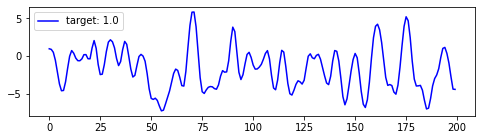

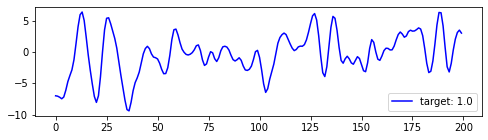

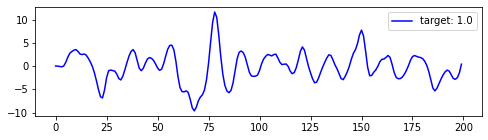

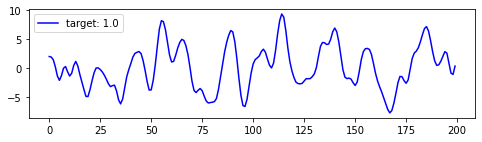

In [18]:
for idx in range(14205-4, 14205):
    fig, (ax1) = plt.subplots(figsize=(8, 2))
    ax1.plot(signal_waveforms[idx], color='blue', label= "target: " + str(y_signal[idx]))
    ax1.legend()
    plt.show()

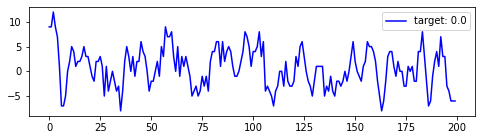

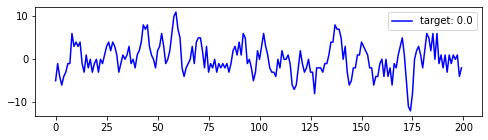

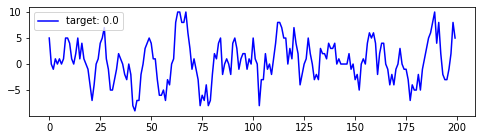

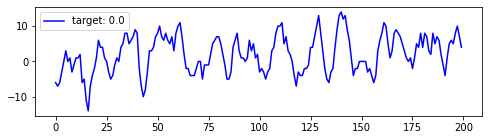

In [19]:
for idx in range(96190-4, 96190):
    fig, (ax1) = plt.subplots(figsize=(8, 2))
    ax1.plot(x_noise_train[idx], color='blue', label= "target: " + str(y_noise_train[idx]))
    ax1.legend()
    plt.show()

In [20]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [21]:
print("training set:    x_train:",x_train.shape, " y_train:",y_train.shape)
print("testing set:     x_test:",x_test.shape, " y_test:",y_test.shape)
print("validation set:  x_valid:",x_valid.shape, " y_valid:",y_valid.shape)

training set:    x_train: (152796, 200)  y_train: (152796,)
testing set:     x_test: (190996, 200)  y_test: (190996,)
validation set:  x_valid: (38200, 200)  y_valid: (38200,)


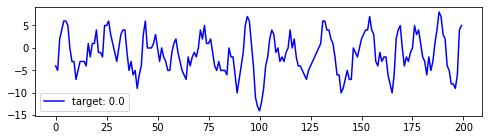

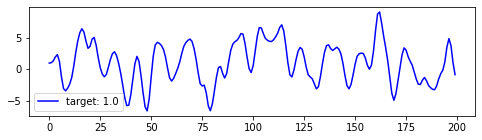

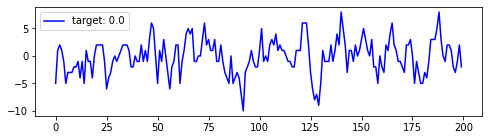

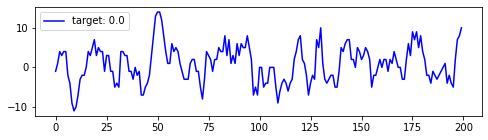

In [22]:
for idx in range(4):
    fig, (ax1) = plt.subplots(figsize=(8, 2))
    ax1.plot(x_train[idx], color='blue', label= "target: " + str(y_train[idx]))
    ax1.legend()
    plt.show()

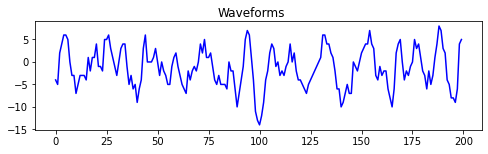

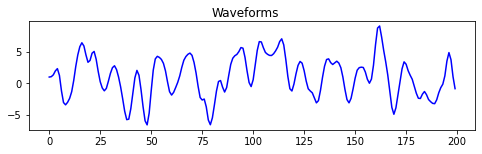

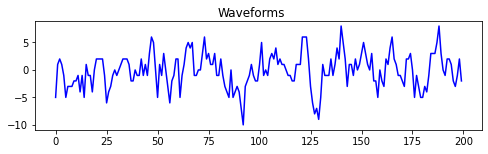

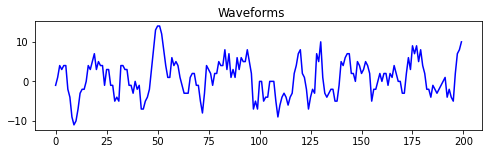

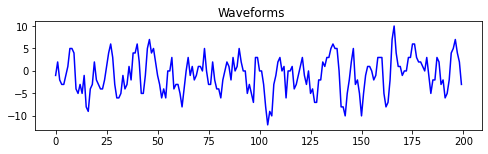

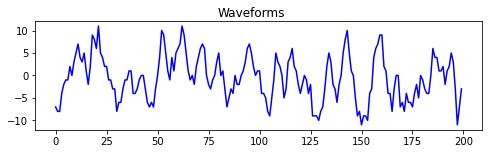

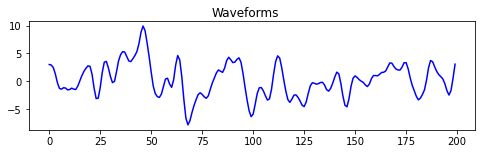

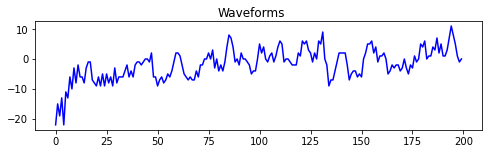

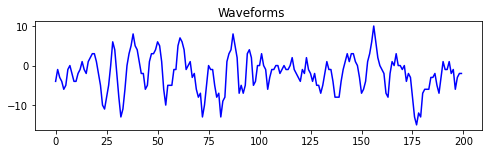

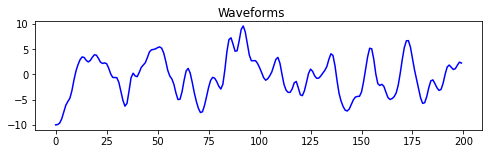

In [23]:
num = 0
for idx in range(num,num+10):
    fig, (ax1) = plt.subplots( figsize=(8, 2))
    fig.suptitle('Waveforms')
    ax1.plot(x_train[idx],color='blue', label='clean')
    ax1.plot(y_train[idx],color='m',alpha=0.7, label='data')

    plt.show()

In [24]:
mean = x_train.mean()
std = x_train.std()

In [25]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std

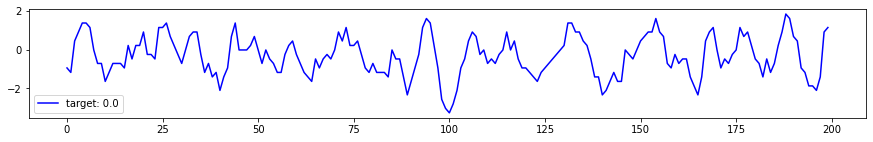

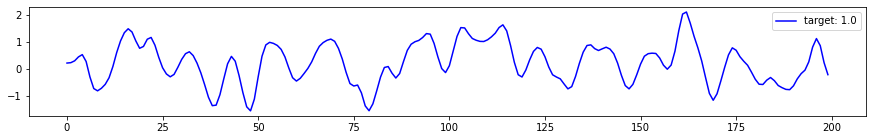

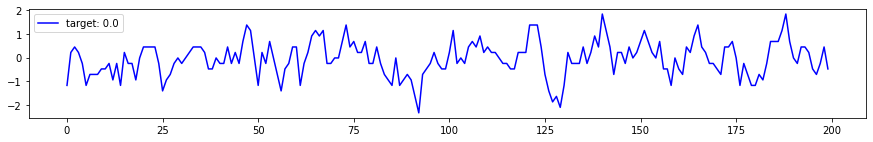

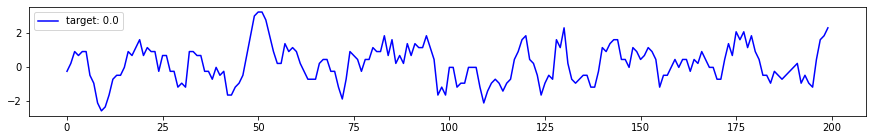

In [26]:
for idx in range(4):
    fig, (ax1) = plt.subplots(figsize=(15, 2))
    ax1.plot(x_train_scaled[idx], color='blue', label= "target: " + str(y_train[idx]))
    ax1.legend()
    plt.show()

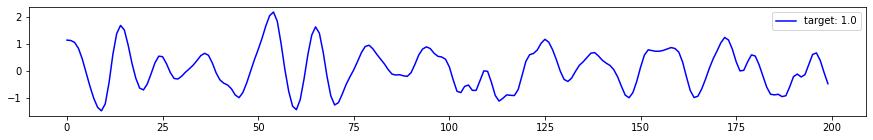

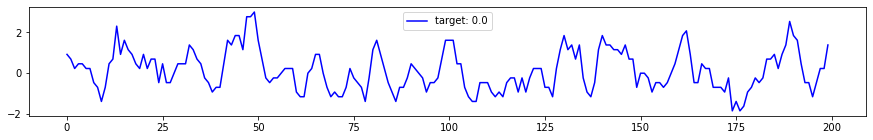

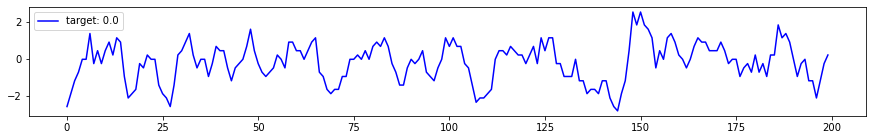

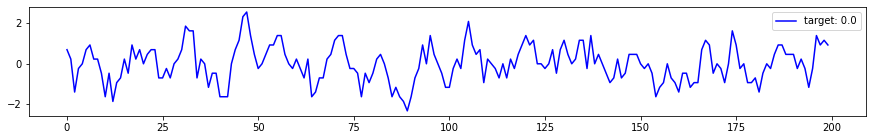

In [27]:
for idx in range(4):
    fig, (ax1) = plt.subplots(figsize=(15, 2))
    ax1.plot(x_valid_scaled[idx], color='blue', label= "target: " + str(y_valid[idx]))
    ax1.legend()
    plt.show()

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

# 1D-CNN LArTPC Waveform Recognition

In [29]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model


model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [30]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.summary()

In [31]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
#cc_x_test_scaled = cc_x_test_scaled.reshape(cc_x_test_scaled.shape[0], cc_x_test_scaled.shape[1], 1)
#es_x_test_scaled = es_x_test_scaled.reshape(es_x_test_scaled.shape[0], es_x_test_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)
print(x_train_scaled.shape[0])
print(x_valid_scaled.shape[0])
print(x_test_scaled.shape[0])

152796
38200
190996


In [32]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(152796, 200, 1) (38200, 200, 1) (190996, 200, 1)


In [33]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [34]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
75/75 [==============================] - 3s 8ms/step - loss: 0.3011 - accuracy: 0.8453 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0075 - accuracy: 0.9999 - val_loss: 7.6813e-04 - val_accuracy: 1.0000
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 7.2471e-04 - accuracy: 1.0000 - val_loss: 1.8251e-04 - val_accuracy: 1.0000
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 2.4496e-04 - accuracy: 1.0000 - val_loss: 6.7889e-05 - val_accuracy: 1.0000
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 1.1383e-04 - accuracy: 1.0000 - val_loss: 3.1090e-05 - val_accuracy: 1.0000
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 6.4255e-05 - accuracy: 1.0000 - val_loss: 1.8038e-05 - val_accuracy: 1.0000
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 4.2087e-05 - accuracy: 1.0000 - val_loss: 1.2

In [ ]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [ ]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


In [ ]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

In [ ]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

In [ ]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
print(auc_keras)

# test

In [ ]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


In [ ]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

In [ ]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()